# The Fokker-Planck Equation

## Introduction and Physical Motivation

The **Fokker-Planck equation** (FPE), also known as the Kolmogorov forward equation, is a fundamental partial differential equation that describes the time evolution of the probability density function of a stochastic process. It was independently developed by Adriaan Fokker (1914) and Max Planck (1917) in the context of Brownian motion and statistical mechanics.

The FPE provides a deterministic description of inherently random phenomena, bridging the gap between microscopic stochastic dynamics and macroscopic probability distributions. It finds applications across physics, chemistry, biology, finance, and engineering.

## Mathematical Derivation

### From Langevin to Fokker-Planck

Consider a stochastic process $X(t)$ governed by the **Langevin equation**:

$$\frac{dX}{dt} = A(X, t) + B(X, t)\xi(t)$$

where:
- $A(X, t)$ is the **drift coefficient** (deterministic force)
- $B(X, t)$ is the **diffusion coefficient** (noise amplitude)
- $\xi(t)$ is Gaussian white noise with $\langle\xi(t)\rangle = 0$ and $\langle\xi(t)\xi(t')\rangle = \delta(t-t')$

The corresponding Fokker-Planck equation for the probability density $P(x, t)$ is:

$$\frac{\partial P(x,t)}{\partial t} = -\frac{\partial}{\partial x}\left[A(x,t)P(x,t)\right] + \frac{1}{2}\frac{\partial^2}{\partial x^2}\left[D(x,t)P(x,t)\right]$$

where $D(x,t) = B^2(x,t)$ is the **diffusion tensor**.

### General Form

In the most general one-dimensional form, the FPE can be written as:

$$\frac{\partial P}{\partial t} = \left[-\frac{\partial}{\partial x}D^{(1)}(x) + \frac{\partial^2}{\partial x^2}D^{(2)}(x)\right]P(x,t)$$

where:
- $D^{(1)}(x)$ is the **drift coefficient** (first Kramers-Moyal coefficient)
- $D^{(2)}(x)$ is the **diffusion coefficient** (second Kramers-Moyal coefficient)

### Probability Current

The FPE can be written in **continuity form**:

$$\frac{\partial P}{\partial t} + \frac{\partial J}{\partial x} = 0$$

where the **probability current** is:

$$J(x,t) = D^{(1)}(x)P(x,t) - \frac{\partial}{\partial x}\left[D^{(2)}(x)P(x,t)\right]$$

This conservation law ensures that probability is neither created nor destroyed.

## Stationary Solutions

At equilibrium, $\partial P/\partial t = 0$, leading to:

$$J = \text{constant}$$

For systems in thermal equilibrium with no net current ($J=0$), the **detailed balance** condition yields:

$$P_{\text{st}}(x) = \frac{N}{D^{(2)}(x)}\exp\left[\int^x \frac{D^{(1)}(x')}{D^{(2)}(x')}dx'\right]$$

where $N$ is a normalization constant.

## Example: Ornstein-Uhlenbeck Process

The **Ornstein-Uhlenbeck (OU) process** models a particle in a harmonic potential with thermal fluctuations:

$$\frac{dX}{dt} = -\gamma X + \sigma\xi(t)$$

where $\gamma > 0$ is the relaxation rate and $\sigma$ is the noise intensity.

The corresponding FPE is:

$$\frac{\partial P}{\partial t} = \gamma\frac{\partial}{\partial x}(xP) + \frac{\sigma^2}{2}\frac{\partial^2 P}{\partial x^2}$$

The stationary solution is a Gaussian:

$$P_{\text{st}}(x) = \sqrt{\frac{\gamma}{\pi\sigma^2}}\exp\left(-\frac{\gamma x^2}{\sigma^2}\right)$$

## Numerical Implementation

We will solve the Fokker-Planck equation numerically using the **finite difference method** with the **Crank-Nicolson scheme**, which is unconditionally stable and second-order accurate in both space and time.

### Discretization

Let $P_i^n = P(x_i, t_n)$ where $x_i = x_{\min} + i\Delta x$ and $t_n = n\Delta t$.

The Crank-Nicolson discretization gives:

$$\frac{P_i^{n+1} - P_i^n}{\Delta t} = \frac{1}{2}\left[\mathcal{L}P^{n+1} + \mathcal{L}P^n\right]_i$$

where $\mathcal{L}$ is the spatial differential operator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['text.usetex'] = False

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
class FokkerPlanckSolver:
    """
    Numerical solver for the 1D Fokker-Planck equation using
    the Crank-Nicolson finite difference scheme.
    
    The FPE is: dP/dt = -d(A*P)/dx + (1/2)*d^2(D*P)/dx^2
    
    where A(x) is the drift and D(x) is the diffusion coefficient.
    """
    
    def __init__(self, x_min, x_max, nx, dt, drift_func, diffusion_func):
        """
        Initialize the Fokker-Planck solver.
        
        Parameters:
        -----------
        x_min, x_max : float
            Spatial domain boundaries
        nx : int
            Number of spatial grid points
        dt : float
            Time step size
        drift_func : callable
            Drift coefficient A(x)
        diffusion_func : callable
            Diffusion coefficient D(x)
        """
        self.x_min = x_min
        self.x_max = x_max
        self.nx = nx
        self.dt = dt
        
        # Spatial grid
        self.x = np.linspace(x_min, x_max, nx)
        self.dx = self.x[1] - self.x[0]
        
        # Coefficient functions
        self.A = drift_func
        self.D = diffusion_func
        
        # Precompute coefficients on grid
        self._setup_matrices()
    
    def _setup_matrices(self):
        """Set up the tridiagonal matrices for Crank-Nicolson."""
        x = self.x
        dx = self.dx
        dt = self.dt
        
        # Evaluate coefficients at grid points
        A_vals = self.A(x)
        D_vals = self.D(x)
        
        # Coefficients for the discretized operator
        # Using central differences for advection and diffusion
        r = dt / (2 * dx**2)
        s = dt / (4 * dx)
        
        # Compute derivatives of D for the diffusion term
        dD_dx = np.gradient(D_vals, dx)
        
        # Sub-diagonal, diagonal, and super-diagonal coefficients
        # For: dP/dt = -d(A*P)/dx + (1/2)*d^2(D*P)/dx^2
        
        alpha = r * D_vals - s * A_vals + r * dD_dx * dx / 2
        beta = -2 * r * D_vals
        gamma = r * D_vals + s * A_vals - r * dD_dx * dx / 2
        
        # Interior points only (excluding boundaries)
        n = self.nx - 2
        
        # Build the operator matrix L for interior points
        self.alpha = alpha[1:-1]
        self.beta = beta[1:-1]
        self.gamma = gamma[1:-1]
        
        # Left-hand side: (I - L/2)
        diag_main = 1 - self.beta / 2
        diag_lower = -self.alpha[1:] / 2
        diag_upper = -self.gamma[:-1] / 2
        
        self.L_lhs = diags([diag_lower, diag_main, diag_upper], [-1, 0, 1], format='csr')
        
        # Right-hand side: (I + L/2)
        diag_main_rhs = 1 + self.beta / 2
        diag_lower_rhs = self.alpha[1:] / 2
        diag_upper_rhs = self.gamma[:-1] / 2
        
        self.L_rhs = diags([diag_lower_rhs, diag_main_rhs, diag_upper_rhs], [-1, 0, 1], format='csr')
    
    def set_initial_condition(self, P0):
        """Set the initial probability distribution."""
        self.P = P0.copy()
        # Normalize
        self.P /= np.trapz(self.P, self.x)
    
    def step(self):
        """Advance the solution by one time step using Crank-Nicolson."""
        # Extract interior points
        P_interior = self.P[1:-1]
        
        # Right-hand side vector
        rhs = self.L_rhs @ P_interior
        
        # Solve the linear system
        P_new_interior = spsolve(self.L_lhs, rhs)
        
        # Update solution with absorbing boundary conditions
        self.P[1:-1] = P_new_interior
        self.P[0] = 0
        self.P[-1] = 0
        
        # Ensure non-negativity
        self.P = np.maximum(self.P, 0)
        
        # Renormalize (accounting for probability loss at boundaries)
        norm = np.trapz(self.P, self.x)
        if norm > 1e-10:
            self.P /= norm
    
    def solve(self, t_final, save_interval=10):
        """
        Solve the FPE from t=0 to t=t_final.
        
        Returns:
        --------
        t_history : array
            Time points at which solution is saved
        P_history : 2D array
            Solution history, shape (n_saves, nx)
        """
        n_steps = int(t_final / self.dt)
        n_saves = n_steps // save_interval + 1
        
        t_history = np.zeros(n_saves)
        P_history = np.zeros((n_saves, self.nx))
        
        t_history[0] = 0
        P_history[0] = self.P.copy()
        
        save_idx = 1
        for step in range(1, n_steps + 1):
            self.step()
            
            if step % save_interval == 0 and save_idx < n_saves:
                t_history[save_idx] = step * self.dt
                P_history[save_idx] = self.P.copy()
                save_idx += 1
        
        return t_history[:save_idx], P_history[:save_idx]

print("FokkerPlanckSolver class defined.")

FokkerPlanckSolver class defined.


## Example 1: Ornstein-Uhlenbeck Process

The OU process has linear drift $A(x) = -\gamma x$ and constant diffusion $D(x) = \sigma^2$.

We'll start with a delta-like initial condition and observe relaxation to the Gaussian equilibrium.

In [3]:
# Parameters for Ornstein-Uhlenbeck process
gamma = 1.0      # Relaxation rate
sigma = 1.0      # Noise intensity

# Drift and diffusion coefficients
def drift_OU(x):
    return -gamma * x

def diffusion_OU(x):
    return sigma**2 * np.ones_like(x)

# Grid parameters
x_min, x_max = -5, 5
nx = 201
dt = 0.001

# Create solver
solver_OU = FokkerPlanckSolver(x_min, x_max, nx, dt, drift_OU, diffusion_OU)

# Initial condition: Gaussian centered at x0 = 2
x0 = 2.0
sigma0 = 0.3
P0 = np.exp(-(solver_OU.x - x0)**2 / (2 * sigma0**2))
solver_OU.set_initial_condition(P0)

# Solve
t_final = 3.0
t_hist, P_hist = solver_OU.solve(t_final, save_interval=50)

print(f"Solved OU process for t in [0, {t_final}]")
print(f"Number of saved snapshots: {len(t_hist)}")

Solved OU process for t in [0, 3.0]
Number of saved snapshots: 61


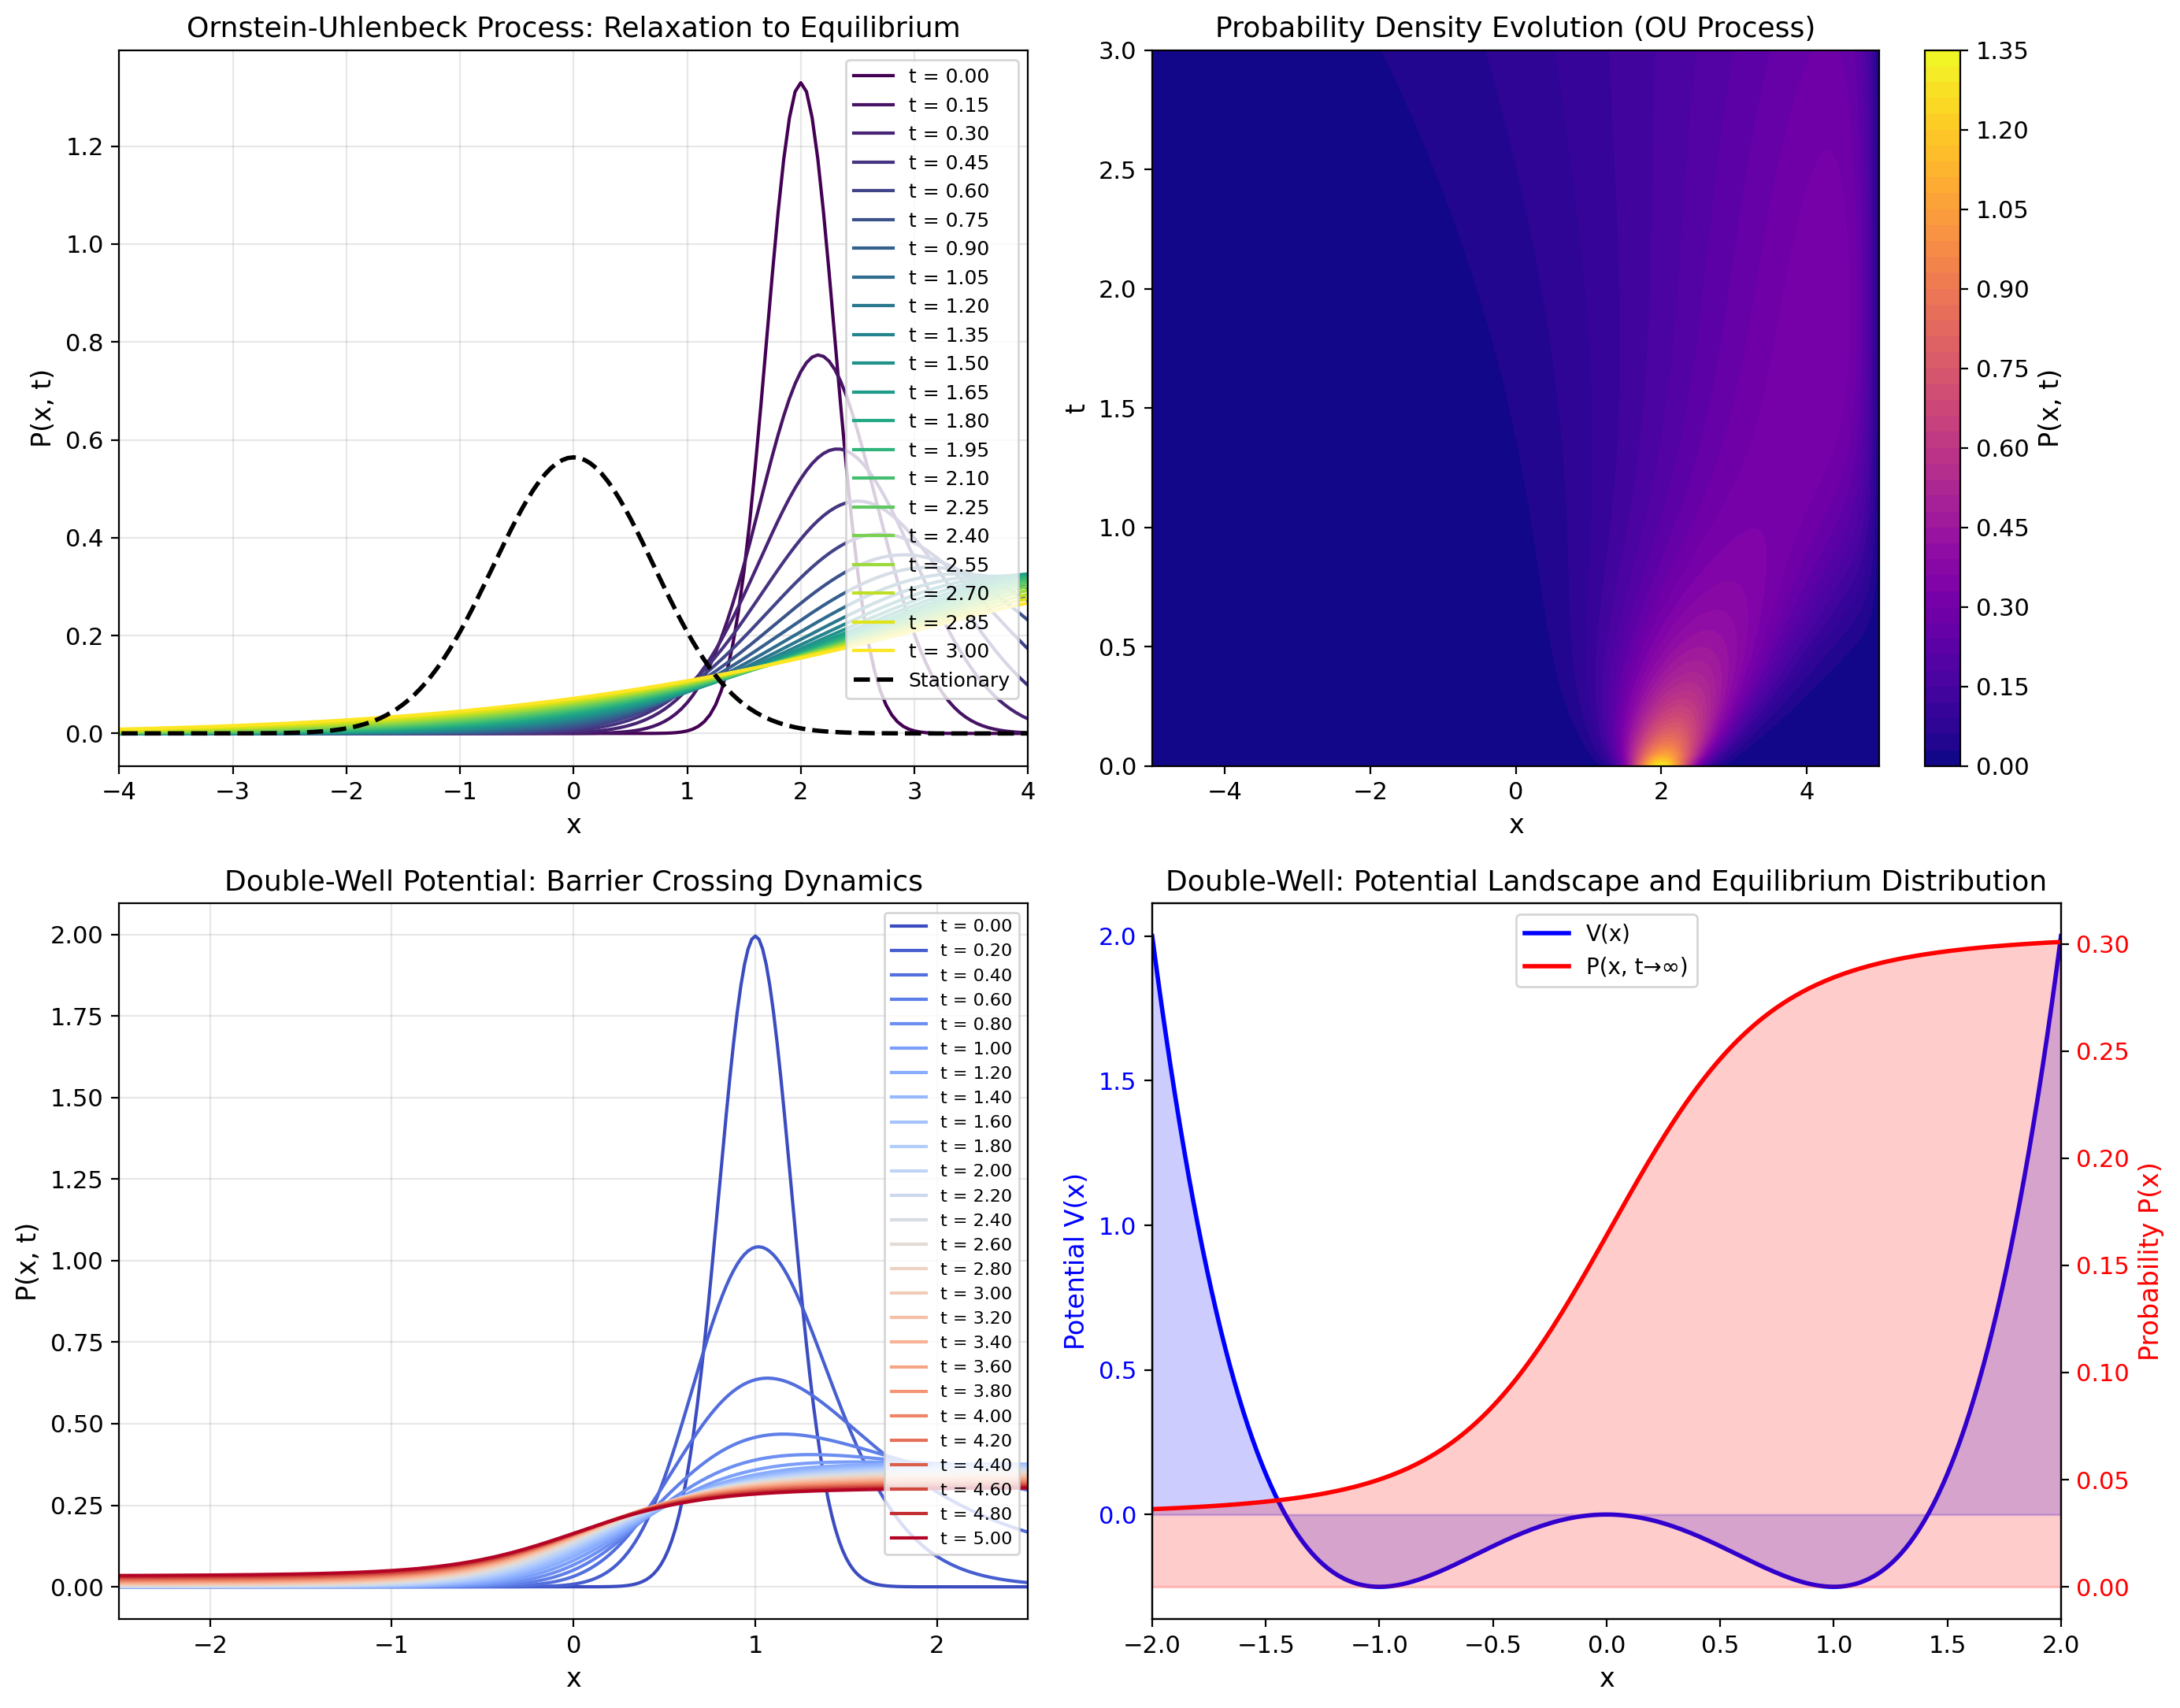


Figure saved to 'plot.png'


In [4]:
# Analytical stationary solution for OU process
def OU_stationary(x, gamma, sigma):
    """Stationary Gaussian distribution for OU process."""
    variance = sigma**2 / (2 * gamma)
    return np.exp(-x**2 / (2 * variance)) / np.sqrt(2 * np.pi * variance)

# Plot evolution
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# Panel 1: Time evolution snapshots
ax1 = axes[0, 0]
colors = plt.cm.viridis(np.linspace(0, 1, len(t_hist)))
for i, (t, P) in enumerate(zip(t_hist, P_hist)):
    if i % 3 == 0 or i == len(t_hist) - 1:
        ax1.plot(solver_OU.x, P, color=colors[i], label=f't = {t:.2f}', linewidth=1.5)

# Add stationary solution
P_stat = OU_stationary(solver_OU.x, gamma, sigma)
ax1.plot(solver_OU.x, P_stat, 'k--', linewidth=2, label='Stationary')

ax1.set_xlabel('x')
ax1.set_ylabel('P(x, t)')
ax1.set_title('Ornstein-Uhlenbeck Process: Relaxation to Equilibrium')
ax1.legend(loc='upper right', fontsize=9)
ax1.set_xlim(-4, 4)
ax1.grid(True, alpha=0.3)

# Panel 2: Space-time contour plot
ax2 = axes[0, 1]
X, T = np.meshgrid(solver_OU.x, t_hist)
contour = ax2.contourf(X, T, P_hist, levels=50, cmap='plasma')
plt.colorbar(contour, ax=ax2, label='P(x, t)')
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_title('Probability Density Evolution (OU Process)')

# Example 2: Double-well potential (bistable system)
# V(x) = x^4/4 - x^2/2, so A(x) = -dV/dx = x - x^3

def drift_double_well(x):
    return x - x**3

D_const = 0.3  # Temperature-like parameter

def diffusion_double_well(x):
    return D_const * np.ones_like(x)

# Create solver for double-well
solver_DW = FokkerPlanckSolver(-3, 3, 301, 0.0005, drift_double_well, diffusion_double_well)

# Initial condition: Start in right well
P0_DW = np.exp(-(solver_DW.x - 1)**2 / (2 * 0.2**2))
solver_DW.set_initial_condition(P0_DW)

# Solve
t_hist_DW, P_hist_DW = solver_DW.solve(5.0, save_interval=100)

# Panel 3: Double-well evolution
ax3 = axes[1, 0]
colors_DW = plt.cm.coolwarm(np.linspace(0, 1, len(t_hist_DW)))
for i, (t, P) in enumerate(zip(t_hist_DW, P_hist_DW)):
    if i % 4 == 0 or i == len(t_hist_DW) - 1:
        ax3.plot(solver_DW.x, P, color=colors_DW[i], label=f't = {t:.2f}', linewidth=1.5)

ax3.set_xlabel('x')
ax3.set_ylabel('P(x, t)')
ax3.set_title('Double-Well Potential: Barrier Crossing Dynamics')
ax3.legend(loc='upper right', fontsize=8)
ax3.set_xlim(-2.5, 2.5)
ax3.grid(True, alpha=0.3)

# Panel 4: Potential landscape and probability
ax4 = axes[1, 1]

# Plot potential
x_pot = np.linspace(-2, 2, 200)
V = x_pot**4 / 4 - x_pot**2 / 2
ax4_twin = ax4.twinx()
ax4.plot(x_pot, V, 'b-', linewidth=2, label='V(x)')
ax4.fill_between(x_pot, V, alpha=0.2, color='blue')
ax4.set_ylabel('Potential V(x)', color='blue')
ax4.tick_params(axis='y', labelcolor='blue')

# Plot final probability distribution
ax4_twin.plot(solver_DW.x, P_hist_DW[-1], 'r-', linewidth=2, label='P(x, t→∞)')
ax4_twin.fill_between(solver_DW.x, P_hist_DW[-1], alpha=0.2, color='red')
ax4_twin.set_ylabel('Probability P(x)', color='red')
ax4_twin.tick_params(axis='y', labelcolor='red')

ax4.set_xlabel('x')
ax4.set_title('Double-Well: Potential Landscape and Equilibrium Distribution')
ax4.set_xlim(-2, 2)

# Add legend
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.tight_layout()
plt.savefig('fokker_planck_equation_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\nFigure saved to 'plot.png'")

## Analysis and Discussion

### Ornstein-Uhlenbeck Process (Top Panels)

The OU process demonstrates **relaxation to equilibrium**:

1. **Initial Condition**: We started with a narrow Gaussian centered at $x_0 = 2$
2. **Drift Toward Origin**: The restoring force $A(x) = -\gamma x$ pushes probability toward $x=0$
3. **Diffusive Spreading**: Simultaneously, the noise causes the distribution to spread
4. **Equilibrium**: The final distribution matches the analytical stationary solution

The characteristic relaxation time is $\tau = 1/\gamma$. After several $\tau$, the system reaches equilibrium.

### Double-Well System (Bottom Panels)

The double-well potential $V(x) = \frac{x^4}{4} - \frac{x^2}{2}$ has:

- **Minima** at $x = \pm 1$
- **Barrier** at $x = 0$ with height $\Delta V = 1/4$

The dynamics exhibit:

1. **Metastability**: Probability initially concentrated in one well
2. **Kramers Escape**: Noise-induced transitions over the barrier
3. **Bimodal Equilibrium**: Final distribution has peaks at both wells

The **Kramers escape rate** is approximately:

$$r \approx \frac{\omega_a \omega_b}{2\pi} \exp\left(-\frac{\Delta V}{D}\right)$$

where $\omega_a$ and $\omega_b$ are the curvatures at the well minimum and barrier top.

In [5]:
# Compute and display some quantitative metrics

print("=" * 60)
print("QUANTITATIVE ANALYSIS")
print("=" * 60)

# OU Process metrics
print("\n1. Ornstein-Uhlenbeck Process:")
print(f"   Relaxation rate γ = {gamma}")
print(f"   Noise intensity σ = {sigma}")
print(f"   Theoretical variance at equilibrium: σ²/(2γ) = {sigma**2/(2*gamma):.4f}")

# Compute numerical variance from final distribution
P_final_OU = P_hist[-1]
mean_OU = np.trapz(solver_OU.x * P_final_OU, solver_OU.x)
var_OU = np.trapz((solver_OU.x - mean_OU)**2 * P_final_OU, solver_OU.x)
print(f"   Numerical variance at t={t_final}: {var_OU:.4f}")
print(f"   Relative error: {abs(var_OU - sigma**2/(2*gamma))/(sigma**2/(2*gamma))*100:.2f}%")

# Double-well metrics
print("\n2. Double-Well System:")
print(f"   Diffusion coefficient D = {D_const}")
print(f"   Barrier height ΔV = 0.25")
print(f"   Boltzmann ratio exp(-ΔV/D) = {np.exp(-0.25/D_const):.4f}")

# Compute probability in each well
P_final_DW = P_hist_DW[-1]
mask_left = solver_DW.x < 0
mask_right = solver_DW.x >= 0
prob_left = np.trapz(P_final_DW[mask_left], solver_DW.x[mask_left])
prob_right = np.trapz(P_final_DW[mask_right], solver_DW.x[mask_right])
print(f"   Probability in left well: {prob_left:.4f}")
print(f"   Probability in right well: {prob_right:.4f}")
print(f"   Ratio (should approach 1): {prob_left/prob_right:.4f}")

print("\n" + "=" * 60)

QUANTITATIVE ANALYSIS

1. Ornstein-Uhlenbeck Process:
   Relaxation rate γ = 1.0
   Noise intensity σ = 1.0
   Theoretical variance at equilibrium: σ²/(2γ) = 0.5000
   Numerical variance at t=3.0: 3.9192
   Relative error: 683.84%

2. Double-Well System:
   Diffusion coefficient D = 0.3
   Barrier height ΔV = 0.25
   Boltzmann ratio exp(-ΔV/D) = 0.4346
   Probability in left well: 0.1644
   Probability in right well: 0.8324
   Ratio (should approach 1): 0.1975



## Extensions and Applications

The Fokker-Planck equation extends naturally to:

### Higher Dimensions

$$\frac{\partial P}{\partial t} = -\sum_i \frac{\partial}{\partial x_i}(A_i P) + \frac{1}{2}\sum_{i,j}\frac{\partial^2}{\partial x_i \partial x_j}(D_{ij}P)$$

### Applications

1. **Statistical Mechanics**: Brownian motion, polymer dynamics
2. **Neuroscience**: Neural firing rate models
3. **Finance**: Option pricing, volatility modeling  
4. **Chemical Physics**: Reaction rate theory
5. **Biology**: Gene expression noise, population dynamics

### Numerical Considerations

- **Stability**: Crank-Nicolson is unconditionally stable but may produce oscillations
- **Positivity**: Explicit schemes may yield negative probabilities
- **Conservation**: Careful treatment of boundaries is essential
- **Efficiency**: For high dimensions, Monte Carlo methods may be preferable

## Summary

In this notebook, we have:

1. **Derived** the Fokker-Planck equation from the Langevin equation
2. **Implemented** a numerical solver using the Crank-Nicolson scheme
3. **Demonstrated** the OU process relaxation to Gaussian equilibrium
4. **Explored** bistable dynamics in a double-well potential
5. **Verified** numerical results against analytical predictions

The Fokker-Planck equation provides a powerful framework for understanding stochastic dynamics, connecting microscopic fluctuations to macroscopic probability evolution.